<a href="https://www.kaggle.com/code/rumitpathare/custom-mobilenetv2-u-net-model-optimised?scriptVersionId=142265375" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Custom U-Net model

Using a custom u-net model to extract the required features from dataset to draw out accurate masking image. My idea is to create a modified encoder insipired by mobile-net V2 as it is light weight and will be faster yet accurate to extract required features from data. As for decoding part is will be similar to u-net with some minor changes to optimize the outcome.bb

In [20]:
import zipfile
from PIL import Image
import io
import csv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch import tensor
from torchinfo import summary
import torch.nn.functional as F


## 1. Checking Data and folder structure

In [2]:
import os
directory = r'/kaggle/input'
for dirname, _, filenames in os.walk(directory):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/carvana-image-masking-challenge/train_masks.zip
/kaggle/input/carvana-image-masking-challenge/29bb3ece3180_11.jpg
/kaggle/input/carvana-image-masking-challenge/train_masks.csv.zip
/kaggle/input/carvana-image-masking-challenge/train.zip
/kaggle/input/carvana-image-masking-challenge/metadata.csv.zip
/kaggle/input/carvana-image-masking-challenge/sample_submission.csv.zip
/kaggle/input/carvana-image-masking-challenge/test.zip
/kaggle/input/carvana-image-masking-challenge/test_hq.zip
/kaggle/input/carvana-image-masking-challenge/train_hq.zip


We can see there are images inside zip file. lets see what kind of data is waiting inside it to suprise us.

## 2. Visualize the Data

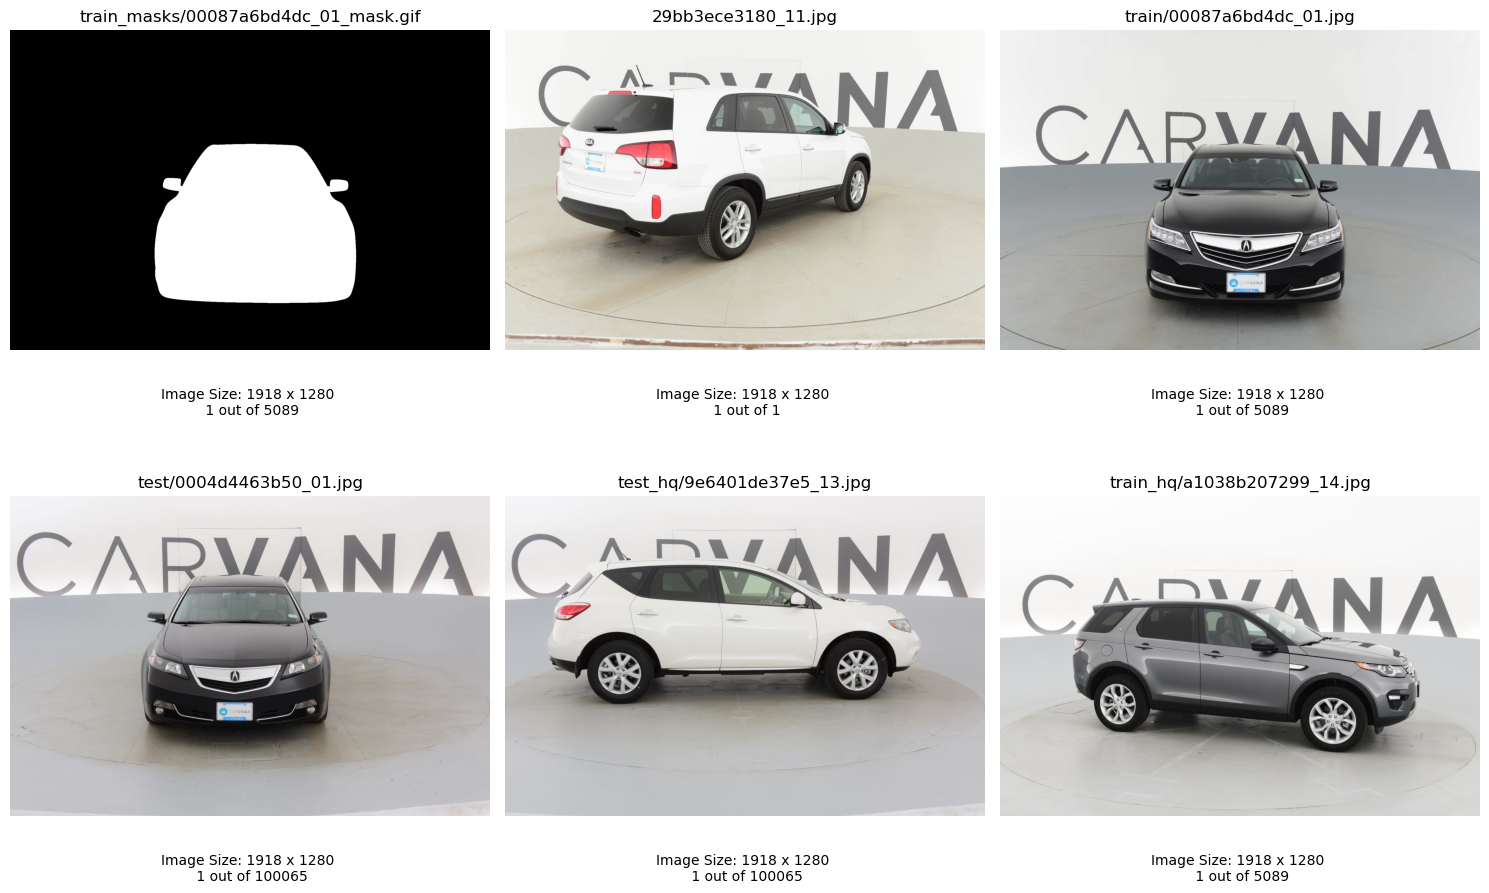


 ----- train_masks.csv ----- 

                   img                                           rle_mask
0  00087a6bd4dc_01.jpg  879386 40 881253 141 883140 205 885009 17 8850...
1  00087a6bd4dc_02.jpg  873779 4 875695 7 877612 9 879528 12 881267 15...
2  00087a6bd4dc_03.jpg  864300 9 866217 13 868134 15 870051 16 871969 ...
3  00087a6bd4dc_04.jpg  879735 20 881650 26 883315 92 883564 30 885208...
4  00087a6bd4dc_05.jpg  883365 74 883638 28 885262 119 885550 34 88716...
Data Size: 5088

 ----- metadata.csv ----- 

             id    year       make   model   trim1                    trim2
0  0004d4463b50  2014.0      Acura      TL      TL                     w/SE
1  00087a6bd4dc  2014.0      Acura     RLX     RLX                   w/Tech
2  000aa097d423  2012.0      Mazda  MAZDA6  MAZDA6                  i Sport
3  000f19f6e7d4  2016.0  Chevrolet  Camaro  Camaro                       SS
4  00144e887ae9  2015.0      Acura     TLX     TLX  SH-AWD V6 w/Advance Pkg
Data Size: 6572

 -----

In [3]:
image_list = []  
csv_list = []

for dirname, _, filenames in os.walk(directory):
    for filename in filenames:
        if filename.endswith(".zip"):
            zipfile_path = os.path.join(dirname, filename)
            with zipfile.ZipFile(zipfile_path, 'r') as zip_ref:
                file_list = zip_ref.infolist()
                #print("No. of files inside ",filename," - ",len(file_list))
                for item in file_list:
                    if item.filename.lower().endswith((".jpg", ".jpeg", ".png", ".gif")):
                        #print("-----",item.filename,"-----")
                        image_data = zip_ref.read(item.filename)
                        img = Image.open(io.BytesIO(image_data))
                        #print(img.size)
                        length = len(file_list)
                        image_list.append((item.filename, img, length))
                        #plt.imshow(img)
                        #plt.title(item.filename)
                        #plt.axis('off')
                        #plt.show()
                        break
                        
                    elif item.filename.lower().endswith(".csv"):
                        #print("-----",item.filename,"-----")
                        csv_data_bytes = zip_ref.read(item.filename)
                        csv_data_text = csv_data_bytes.decode("utf-8")
                        csv_file_obj = io.StringIO(csv_data_text)
                        df = pd.read_csv(csv_file_obj)
                        #print(df.head())
                        csv_list.append((item.filename, csv_data_text))
                        break
                            
        else:
            zipfile_path = os.path.join(dirname, filename)
            image = Image.open(zipfile_path)
            image_list.append((filename, image, 1))
            #plt.imshow(image)
            #plt.title(filename)
            #plt.axis('off')
            #plt.show()
            
num_rows = 2 
num_cols = (len(image_list) + 1) // num_rows

plt.figure(figsize=(15, 10))

for i, (img_filename, img, length) in enumerate(image_list, 1):
    plt.subplot(num_rows, num_cols, i)
    plt.imshow(img)
    plt.title(img_filename)
    plt.axis('off')
    img_size = img.size
    plt.annotate(f"Image Size: {img_size[0]} x {img_size[1]} \n 1 out of {length}", xy=(0.5, -0.2), ha='center', fontsize=10, xycoords='axes fraction')

plt.tight_layout()
plt.show()

# Display CSV data
for csv_filename, csv_data_text in csv_list:
    print("\n -----", csv_filename, "----- \n")
    csv_file_obj = io.StringIO(csv_data_text)
    df = pd.read_csv(csv_file_obj)
    print(df.head())
    print(f"Data Size: {len(df)}")

Looking at the contents inside zip there is a lot of details available about data, but i am only interested in train.zip and train_mask.zip as images in them match and will be useful for training. Now to extract those zip files and save them on HDD so that images loading directly from zip will utilize excess RAM or GPU memory.

## 3. Saving Data

In [4]:
extract_path = '/kaggle/working/'  # Replace this with the path where you want to extract the contents

for dirname, _, filenames in os.walk(directory):
    for filename in filenames:
        if filename in ["train.zip", "train_masks.zip"]:
            print(filename)
            zipfile_path = os.path.join(dirname, filename)
            with zipfile.ZipFile(zipfile_path, 'r') as zip_ref:
                zip_ref.extractall(extract_path)
                print("Extraction complete.")

train_masks.zip
Extraction complete.
train.zip
Extraction complete.


Visualizing the Data after extracting the zip files

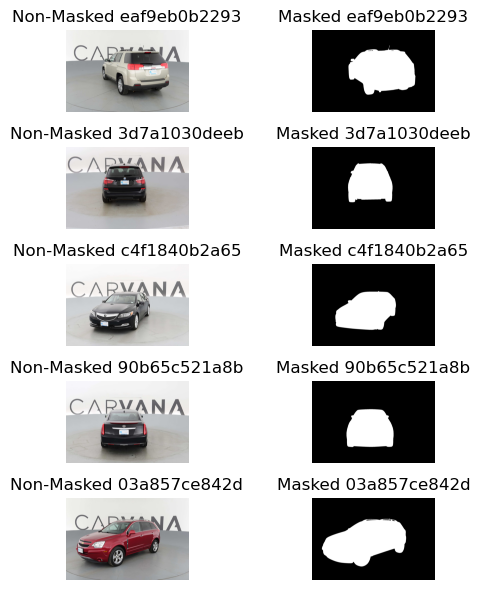

In [5]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(6, 6))
for root, dirs, filenames in os.walk(extract_path):
    c = 0
    for filename in filenames:
        if c >= 5:
            break
        if 'train_masks' in root:
            
            image_path = os.path.join(root.replace('train_masks', 'train'), filename.split("_")[0]+"_"+filename.split("_")[1]+".jpg")
            mask_path = os.path.join(root, filename)
            
            img = Image.open(image_path)
            img_mask = Image.open(mask_path)
            
            axes[c][0].imshow(img)
            axes[c][0].set_title(f"Non-Masked {filename.split('_')[0]}")
            axes[c][0].axis('off')
            
            axes[c][1].imshow(img_mask)
            axes[c][1].set_title(f"Masked {filename.split('_')[0]}")
            axes[c][1].axis('off')
            
            c += 1

plt.tight_layout()
plt.show()


Data looks quite fine to load into the data loader to train it.

## 4. Loading the Data

Looking at the data we hae to manually match the image name to its mask and add into the data loader.

In [37]:
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms


preprocess_X = transforms.Compose([
            transforms.Resize((512, 512)),
            transforms.ToTensor(),
            transforms.Normalize(mean=(0,0,0),std=(1,1,1))])

preprocess_y = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
            transforms.Normalize(mean=(0),std=(1))])

class CustomDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform_X=None, transform_y=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform_X = transform_X
        self.transform_y = transform_y

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx])
        mask = Image.open(self.mask_paths[idx])
        
        if self.transform_X:
            image = self.transform_X(image)
        if self.transform_y:
            mask = self.transform_y(mask)
        
        return image, mask

In [38]:
from tqdm import tqdm

train_img_X = []
train_img_y = []

for root, dirs, filenames in os.walk(extract_path):
    for filename in tqdm(filenames, desc="Processing images"):
        if 'train_masks' in root:
            image_path = os.path.join(root.replace('train_masks', 'train'), filename.split("_")[0] + "_" + filename.split("_")[1] + ".jpg")
            mask_path = os.path.join(root, filename)
            
            train_img_X.append(image_path)
            train_img_y.append(mask_path)

dataset = CustomDataset(train_img_X, train_img_y, transform_X=preprocess_X, transform_y=preprocess_y)
print("Dataset processing complete.")

Processing images: 0it [00:00, ?it/s]
Processing images: 0it [00:00, ?it/s]
Processing images: 100%|██████████| 5088/5088 [00:00<00:00, 1437659.58it/s]

Dataset processing complete.


## 5. Split the Data

split the data into Image into X and mask into y further splitting it into training and testing.

In [39]:
train_size = int(0.9 * len(dataset))
test_size = len(dataset) - train_size  

train_subset = Subset(dataset, range(train_size))
test_subset = Subset(dataset, range(train_size, len(dataset)))

In [40]:
batch_size = 8

train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)

In [41]:
train_X_batch, train_y_batch = next(iter(train_loader))
print(train_X_batch.shape, train_y_batch.shape)
print(f"Length of train dataloader: {len(train_loader)}")

torch.Size([8, 3, 512, 512]) torch.Size([8, 1, 256, 256])
Length of train dataloader: 573


In [42]:
for batch in train_loader:
    image_x_batch, image_y_batch = batch
    break
    
print("Input Image shape: ",image_x_batch.shape)
print("Output Mask shape: ",image_y_batch.shape)

Input Image shape:  torch.Size([8, 3, 512, 512])
Output Mask shape:  torch.Size([8, 1, 256, 256])


Visualize the data after loading to see if pairing is done right

Image size: torch.Size([3, 512, 512])
Masked image size: torch.Size([1, 256, 256])


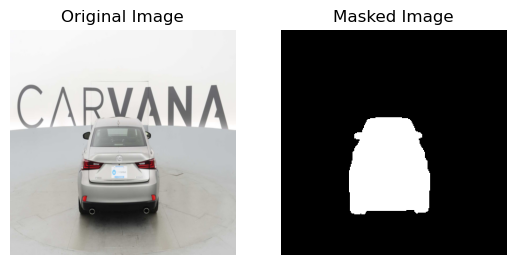

In [43]:
random_idx = torch.randint(0, len(train_X_batch), size=[1]).item()
#print(random_idx)
img_X, img_y = train_X_batch[random_idx], train_y_batch[random_idx]
fig,axes = plt.subplots(1, 2)
img_array = img_X.permute(1, 2, 0).cpu().numpy()
axes[0].imshow(img_array)
axes[0].set_title('Original Image')
axes[0].axis("Off")
mask_array = img_y.permute(1, 2, 0).cpu().numpy()
axes[1].imshow(mask_array, cmap="gray")
axes[1].set_title('Masked Image')
axes[1].axis("Off");
print(f"Image size: {img_X.shape}")
print(f"Masked image size: {img_y.shape}")

### Device agnostic code

In [44]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 6. Creating a Cnn Model

Now that the data has been properly generated, Its time to Create a desired model to train the data.

In [76]:
class Conv2dNormActivation(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, groups):
        super(Conv2dNormActivation, self).__init__()
        
        if in_channels == out_channels:
            self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, groups=groups, bias=False)
        else:
            self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu6 = nn.ReLU6(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu6(x)
        return x

class InvertedResidual(nn.Module):
    def __init__(self, in_channels, out_channels, stride, exp):
        super(InvertedResidual, self).__init__()
        
        self.residual_connection = True if stride == 1 and in_channels == out_channels else False
        
        if exp == 1:
            self.conv = nn.Sequential(
                Conv2dNormActivation(in_channels*exp, in_channels*exp, kernel_size=3, stride=stride, padding=1, groups=in_channels*exp),
                nn.Conv2d(in_channels*exp, out_channels, kernel_size=1, stride=1, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.conv = nn.Sequential(
                    Conv2dNormActivation(in_channels, in_channels*exp, kernel_size=1, stride=1, padding=0, groups=in_channels*exp),
                    Conv2dNormActivation(in_channels*exp, in_channels*exp, kernel_size=3, stride=stride, padding=1, groups=in_channels*exp),
                    nn.Conv2d(in_channels*exp, out_channels, kernel_size=1, stride=1, bias=False),
                    nn.BatchNorm2d(out_channels)
                )

    def forward(self, x):
        output = self.conv(x)
        if self.residual_connection:
            output = x + self.conv(x)
        return output

class MobileNetV2(nn.Module):
    def __init__(self, input_ch = 3, hidden = 32):
        super(MobileNetV2, self).__init__()
        self.features = self._make_layers(input_ch, hidden)

    def _make_layers(self, input_ch, hidden):
        ###          channels, iteration, stride, expansion
        net_info = [[16, 1, 1, 1],
                    [24, 2, 2, 6],
                    [32, 3, 2, 6],
                    [64, 4, 2, 6],
                    [96, 3, 1, 6],
                    [160, 3, 2, 6],
                    [320, 1, 1, 6]]

        input_channel = hidden
        layers = []
        layers.append(Conv2dNormActivation(input_ch, input_channel, kernel_size=3, stride=2, padding=1, groups=0))

        for channel, itr, stride, expansion in net_info:
            for i in range(itr):
                layers.append(InvertedResidual(in_channels=input_channel, out_channels=channel, exp=expansion, stride=stride))
                input_channel = channel
                stride=1
                
        layers.append(Conv2dNormActivation(320, 1024, kernel_size=1, stride=2, padding=0, groups=0))

        return nn.Sequential(*layers)

    def forward(self, x):
        x1 = self.features[:2](x)
        x2 = self.features[2:4](x1)
        x3 = self.features[4:7](x2)
        x4 = self.features[7:11](x3)
        x5 = self.features[11:14](x4)
        x6 = self.features[14:17](x5)
        x7 = self.features[17:18](x6)
        x8 = self.features[18:](x7)
        return x1, x2, x3, x4, x5, x6, x7, x8
    
class Upsample_Block(nn.Module):
    def __init__(self,in_ch,out_ch,skip_ch,scale):
        super().__init__()
        
        #skip_ch.shape[-1]/in_ch.shape[-1] 
        self.upsample = nn.Upsample(scale_factor=scale, mode='bilinear', align_corners=True)
        self.bn = nn.BatchNorm2d(num_features=in_ch+skip_ch)
        self.conv1 = nn.Conv2d(in_channels=in_ch+skip_ch, out_channels=out_ch, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=out_ch, out_channels=out_ch, kernel_size=3, padding=1)
   

    def forward(self,x,skip):
        #print(x.shape)
        up = self.upsample(x)
        #print(up.shape, skip.shape)
        out = torch.cat((skip,up),axis=1)
        out = self.bn(out)
        out = F.relu(self.conv1(out))
        out = F.relu(self.conv2(out))
        return out

class Modified_Unet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.encoder = MobileNetV2(input_ch=3, hidden=24)

        self.dblock1 = Upsample_Block(1024,320,320,2)
        self.dblock2 = Upsample_Block(320,160,160,1)
        self.dblock3 = Upsample_Block(160,96,96,2)
        self.dblock4 = Upsample_Block(96,64,64,1)
        self.dblock5 = Upsample_Block(64,32,32,2)
        self.dblock6 = Upsample_Block(32,24,24,2)
        self.dblock7 = Upsample_Block(24,16,16,2)
        
        self.conv = nn.Conv2d(16,1,kernel_size=3,padding=1)

    def forward(self,x):
        
        d1, d2, d3, d4, d5, d6, d7, d8 = self.encoder(x)
        
        u1 = self.dblock1(d8,d7)
        u2 = self.dblock2(u1,d6) 
        u3 = self.dblock3(u2,d5)
        u4 = self.dblock4(u3,d4)
        u5 = self.dblock5(u4,d3)
        u6 = self.dblock6(u5,d2)
        u7 = self.dblock7(u6,d1)

        out = self.conv(u7)

        return out

In [77]:
model_1 = Modified_Unet()
model_1 = model_1.to(device)
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(),
                        lr=0.001)

In [78]:
pip install torch.summary

Note: you may need to restart the kernel to use updated packages.


In [79]:
from torchsummary import summary
summary(model_1, input_size=(8, 3, 512, 512))

Layer (type:depth-idx)                        Param #
├─MobileNetV2: 1-1                            --
|    └─Sequential: 2-1                        --
|    |    └─Conv2dNormActivation: 3-1         696
|    |    └─InvertedResidual: 3-2             680
|    |    └─InvertedResidual: 3-3             5,136
|    |    └─InvertedResidual: 3-4             8,832
|    |    └─InvertedResidual: 3-5             10,000
|    |    └─InvertedResidual: 3-6             14,848
|    |    └─InvertedResidual: 3-7             14,848
|    |    └─InvertedResidual: 3-8             21,056
|    |    └─InvertedResidual: 3-9             54,272
|    |    └─InvertedResidual: 3-10            54,272
|    |    └─InvertedResidual: 3-11            54,272
|    |    └─InvertedResidual: 3-12            66,624
|    |    └─InvertedResidual: 3-13            118,272
|    |    └─InvertedResidual: 3-14            118,272
|    |    └─InvertedResidual: 3-15            155,264
|    |    └─InvertedResidual: 3-16            320,000
|   

Layer (type:depth-idx)                        Param #
├─MobileNetV2: 1-1                            --
|    └─Sequential: 2-1                        --
|    |    └─Conv2dNormActivation: 3-1         696
|    |    └─InvertedResidual: 3-2             680
|    |    └─InvertedResidual: 3-3             5,136
|    |    └─InvertedResidual: 3-4             8,832
|    |    └─InvertedResidual: 3-5             10,000
|    |    └─InvertedResidual: 3-6             14,848
|    |    └─InvertedResidual: 3-7             14,848
|    |    └─InvertedResidual: 3-8             21,056
|    |    └─InvertedResidual: 3-9             54,272
|    |    └─InvertedResidual: 3-10            54,272
|    |    └─InvertedResidual: 3-11            54,272
|    |    └─InvertedResidual: 3-12            66,624
|    |    └─InvertedResidual: 3-13            118,272
|    |    └─InvertedResidual: 3-14            118,272
|    |    └─InvertedResidual: 3-15            155,264
|    |    └─InvertedResidual: 3-16            320,000
|   

## 7. Model Training and Forward Propogation

In [82]:
torch.manual_seed(42)

Epochs = 3

for epoch in tqdm(range(Epochs)):
    print(f"Epoch: {epoch}\n-------")
    train_loss = 0
    for batch, (X_train_image, y_train_image) in enumerate(train_loader):
        model_1.train()
        y_train_pred = model_1(X_train_image.to(device))
        loss = loss_fn(y_train_pred.to('cpu'), y_train_image)
        train_loss += loss 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch % 20 == 0:
            print(f"Looked at {batch * len(X_train_image)}/{len(train_loader.dataset)} samples")
        train_loss /= len(train_loader)
    test_loss = 0
    model_1.eval()
    with torch.inference_mode():
        for X_test_image, y_test_image in test_loader:
            test_pred = model_1(X_test_image.to(device))       
            test_loss += loss_fn(test_pred.to('cpu'), y_test_image)
        test_loss /= len(test_loader)
    print(f"\nTrain loss: {train_loss:.5f} | Test loss: {test_loss:.5f}")

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-------
Looked at 0/4579 samples
Looked at 160/4579 samples
Looked at 320/4579 samples
Looked at 480/4579 samples
Looked at 640/4579 samples
Looked at 800/4579 samples
Looked at 960/4579 samples
Looked at 1120/4579 samples
Looked at 1280/4579 samples
Looked at 1440/4579 samples
Looked at 1600/4579 samples
Looked at 1760/4579 samples
Looked at 1920/4579 samples
Looked at 2080/4579 samples
Looked at 2240/4579 samples
Looked at 2400/4579 samples
Looked at 2560/4579 samples
Looked at 2720/4579 samples
Looked at 2880/4579 samples
Looked at 3040/4579 samples
Looked at 3200/4579 samples
Looked at 3360/4579 samples
Looked at 3520/4579 samples
Looked at 3680/4579 samples
Looked at 3840/4579 samples
Looked at 4000/4579 samples
Looked at 4160/4579 samples
Looked at 4320/4579 samples
Looked at 4480/4579 samples


 33%|███▎      | 1/3 [04:10<08:21, 250.65s/it]


Train loss: 0.00001 | Test loss: 0.00560
Epoch: 1
-------
Looked at 0/4579 samples
Looked at 160/4579 samples
Looked at 320/4579 samples
Looked at 480/4579 samples
Looked at 640/4579 samples
Looked at 800/4579 samples
Looked at 960/4579 samples
Looked at 1120/4579 samples
Looked at 1280/4579 samples
Looked at 1440/4579 samples
Looked at 1600/4579 samples
Looked at 1760/4579 samples
Looked at 1920/4579 samples
Looked at 2080/4579 samples
Looked at 2240/4579 samples
Looked at 2400/4579 samples
Looked at 2560/4579 samples
Looked at 2720/4579 samples
Looked at 2880/4579 samples
Looked at 3040/4579 samples
Looked at 3200/4579 samples
Looked at 3360/4579 samples
Looked at 3520/4579 samples
Looked at 3680/4579 samples
Looked at 3840/4579 samples
Looked at 4000/4579 samples
Looked at 4160/4579 samples
Looked at 4320/4579 samples
Looked at 4480/4579 samples


 67%|██████▋   | 2/3 [08:21<04:10, 250.60s/it]


Train loss: 0.00001 | Test loss: 0.00559
Epoch: 2
-------
Looked at 0/4579 samples
Looked at 160/4579 samples
Looked at 320/4579 samples
Looked at 480/4579 samples
Looked at 640/4579 samples
Looked at 800/4579 samples
Looked at 960/4579 samples
Looked at 1120/4579 samples
Looked at 1280/4579 samples
Looked at 1440/4579 samples
Looked at 1600/4579 samples
Looked at 1760/4579 samples
Looked at 1920/4579 samples
Looked at 2080/4579 samples
Looked at 2240/4579 samples
Looked at 2400/4579 samples
Looked at 2560/4579 samples
Looked at 2720/4579 samples
Looked at 2880/4579 samples
Looked at 3040/4579 samples
Looked at 3200/4579 samples
Looked at 3360/4579 samples
Looked at 3520/4579 samples
Looked at 3680/4579 samples
Looked at 3840/4579 samples
Looked at 4000/4579 samples
Looked at 4160/4579 samples
Looked at 4320/4579 samples
Looked at 4480/4579 samples


100%|██████████| 3/3 [12:32<00:00, 250.73s/it]


Train loss: 0.00001 | Test loss: 0.00558


In [83]:
torch.save(model_1.state_dict(), 'MobileNetV2_Unet_wts.pth')
torch.save(model_1,'MobileNetV2_Unet_model.pth')

## Checking the output

Image size: torch.Size([3, 512, 512])
Masked image size: torch.Size([1, 256, 256])


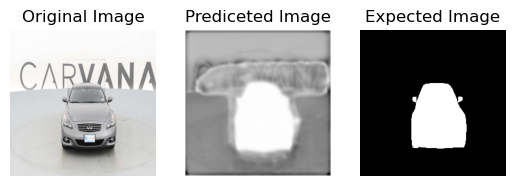

In [84]:
random_idx = torch.randint(0, len(train_X_batch), size=[1]).item()
#print(random_idx)
img_X, img_y = train_X_batch[random_idx], train_y_batch[random_idx]
predicted_image = model_1(img_X.unsqueeze(0).to(device))

fig,axes = plt.subplots(1, 3)
img_array = img_X.permute(1, 2, 0).cpu().numpy()
axes[0].imshow(img_array)
axes[0].set_title('Original Image')
axes[0].axis("Off")

img_array = predicted_image.squeeze().detach().cpu().numpy()
axes[1].imshow(img_array, cmap='gray')
axes[1].set_title('Prediceted Image')
axes[1].axis("Off")

mask_array = img_y.permute(1, 2, 0).cpu().numpy()
axes[2].imshow(mask_array, cmap="gray")
axes[2].set_title('Expected Image')
axes[2].axis("Off")

print(f"Image size: {img_X.shape}")
print(f"Masked image size: {img_y.shape}")